# TP N°3 — Minería de Datos (TUIA)
**Año:** 2025 • **Materia:** Data Mining • **Integrantes:** Fabrizio Tapia, Sebastian Palacio

**Datasets:**  
- dxWeather.csv (Predicción de estaciones) https://www.kaggle.com/datasets/nikhil7280/weather-type-classification/

**Objetivo:**  
Integrar los conocimientos adquiridos en las unidades 5 y 6 en un problema real asociado a la determinación de la estación del año mediante la medición de atributos característicos

## Carga y Exploración Inicial del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')


In [2]:
estaciones = pd.read_csv('dxWeather.csv')

print("INFORMACIÓN GENERAL DEL DATASET \n")
print(f"Dimensiones: {estaciones.shape[0]} filas x {estaciones.shape[1]} columnas")
print(f"\nColumnas: {list(estaciones.columns)}")
print(f"\nTipos de datos:")
print(estaciones.dtypes)

INFORMACIÓN GENERAL DEL DATASET 

Dimensiones: 10090 filas x 8 columnas

Columnas: ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica', 'Localizacion', 'TipoClima', 'Estacion']

Tipos de datos:
Temperatura             int64
Humedad                 int64
VientoVelocidad       float64
Precipitation           int64
PresionAtmosferica    float64
Localizacion           object
TipoClima              object
Estacion               object
dtype: object


In [3]:
estaciones.head()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica,Localizacion,TipoClima,Estacion
0,39,96,8.5,71,1011.43,Llanura,Nublado,Primavera
1,30,64,7.0,16,1018.72,Montania,Soleado,Primavera
2,38,83,1.5,82,1026.25,Costa,Soleado,Primavera
3,32,55,3.5,26,1010.03,Llanura,Nublado,Verano
4,3,85,6.0,96,984.46,Llanura,Nevado,Invierno


In [4]:
diccionario_variables = {
    'Temperatura': 'Temperatura medida en grados Celsius',
    'Humedad': 'Humedad medida en porcentaje',
    'VientoVelocidad': 'Velocidad del viento medida en km/h',
    'Precipitation': 'Precipitación medida en porcentaje',
    'PresionAtmosferica': 'Presión atmosférica medida en hPa',
    'Localizacion': 'Localización de donde fue tomada la medición',
    'TipoClima': 'Tipo de clima',
    'Estacion': 'Estación meteorológica (target)'
}

print("DICCIONARIO DE VARIABLES \n")

for variable, descripcion in diccionario_variables.items():
    print(f"• {variable:20s} → {descripcion}")

DICCIONARIO DE VARIABLES 

• Temperatura          → Temperatura medida en grados Celsius
• Humedad              → Humedad medida en porcentaje
• VientoVelocidad      → Velocidad del viento medida en km/h
• Precipitation        → Precipitación medida en porcentaje
• PresionAtmosferica   → Presión atmosférica medida en hPa
• Localizacion         → Localización de donde fue tomada la medición
• TipoClima            → Tipo de clima
• Estacion             → Estación meteorológica (target)


In [5]:
estaciones.describe()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica
count,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000
mean,21.872349,67.195045,9.634936,50.796333,1007.685836
std,16.426722,20.463797,6.795890,32.333798,38.763971
min,-24.000000,20.000000,0.000000,0.000000,800.230000
25%,13.000000,55.000000,5.000000,18.000000,998.570000
50%,23.000000,69.000000,8.500000,53.000000,1010.315000
75%,32.000000,81.000000,13.500000,80.000000,1017.820000
max,109.000000,109.000000,47.500000,109.000000,1199.210000


Desde este punto ya podemos ver algunos valores imposibles como porcentajes superiores a 100% y temperaturas maximas de 109ºC (Mayor que la temperatura a la que hierve el agua)

In [6]:
print("VALORES FALTANTES:\n")

faltantes = estaciones.isnull().sum()

faltantes_pct = (faltantes / len(estaciones)) * 100

df_faltantes = pd.DataFrame({
    'Columna': faltantes.index,
    'Valores Faltantes': faltantes.values,
    'Porcentaje': faltantes_pct.values
})

print(df_faltantes)
print("\n")

print(f"DUPLICADOS: {estaciones.duplicated().sum()}")


VALORES FALTANTES:

              Columna  Valores Faltantes  Porcentaje
0         Temperatura                  0         0.0
1             Humedad                  0         0.0
2     VientoVelocidad                  0         0.0
3       Precipitation                  0         0.0
4  PresionAtmosferica                  0         0.0
5        Localizacion                  0         0.0
6           TipoClima                  0         0.0
7            Estacion                  0         0.0


DUPLICADOS: 0


No encontramos valores faltantes ni duplicados en este dataset

# 3.1 Análisis Exploratorio de Datos (EDA)

## Valores imposibles

En base a lo visto en la descripcion del dataset, consideramos conveniente filtrar directamente los valores imposibles

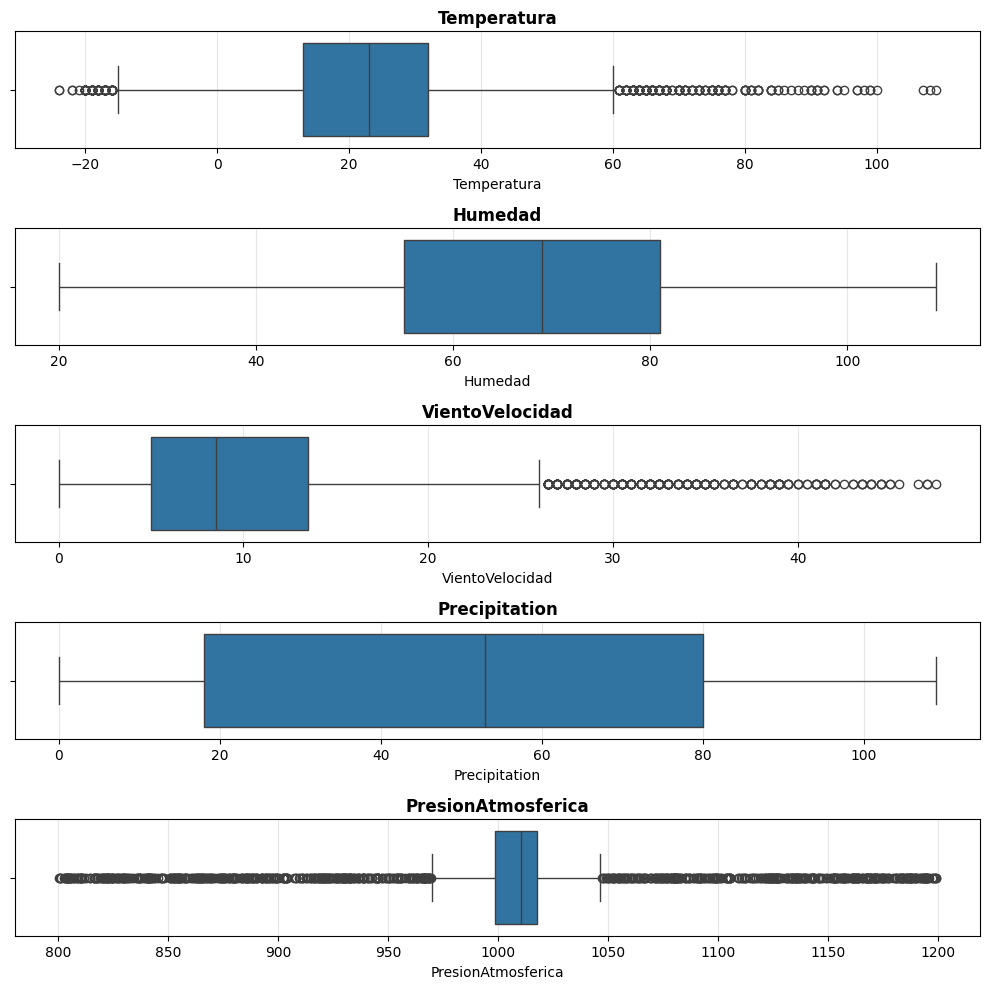

In [7]:
# Boxplot de las variables numéricas (uno debajo del otro)
fig, axes = plt.subplots(5, 1, figsize=(10, 10))

columnas_numericas = ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica']

for i, col in enumerate(columnas_numericas):
    sns.boxplot(x=estaciones[col], ax=axes[i], orient='h')
    axes[i].set_xlabel(col)
    axes[i].set_title(f'{col}', fontweight='bold')
    axes[i].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

Valores previo a limpieza de datos y outliers

### Limpieza de datos y outliers

In [8]:
#Temperaturas Extremadamente Altas e imposibles (mayores 45°C y 100°C)
temp_extrema = estaciones[(estaciones['Temperatura'] > 45)]
conteo_extremo = len(temp_extrema)
print(f"Número de registros con Temperatura mayores a 45°C: {conteo_extremo}")


#Valores imposibles de "Humedad"
humedad_imposible = estaciones[(estaciones['Humedad'] < 0) | (estaciones['Humedad'] > 100)]
conteo_humedad_imposible = len(humedad_imposible)
print(f"Número de registros con Humedad fuera del rango 0-100%: {conteo_humedad_imposible}")


#Valores imposibles de "Precipitación"
precipitacion_imposible = estaciones[(estaciones['Precipitation'] < 0) | (estaciones['Precipitation'] > 100)]
conteo_precipitacion_imposible = len(precipitacion_imposible)
print(f"Número de registros con Precipitación negativa: {conteo_precipitacion_imposible}")


#Valores extremadamente altos de viento
viento_imposible = estaciones[(estaciones['VientoVelocidad'] > 25)]
conteo_viento_imposible = len(viento_imposible)
print(f"Número de registros con Velocidad del Viento imposible: {conteo_viento_imposible}")

#Valores imposibles de "PresionAtmosferica"
presion_imposible = estaciones[(estaciones['PresionAtmosferica'] < 960) | (estaciones['PresionAtmosferica'] > 1050)]
conteo_presion_imposible = len(presion_imposible)
print(f"Número de registros con Presión Atmosférica fuera del rango 940-1080 hPa: {conteo_presion_imposible}")


print("="*80)

#Total
total_imposibles = (conteo_extremo + conteo_humedad_imposible +
                    conteo_precipitacion_imposible + conteo_viento_imposible + 
                    conteo_presion_imposible)
print(f"Número total de registros con valores imposibles: {total_imposibles}")

Número de registros con Temperatura mayores a 45°C: 443
Número de registros con Humedad fuera del rango 0-100%: 314
Número de registros con Precipitación negativa: 291
Número de registros con Velocidad del Viento imposible: 317
Número de registros con Presión Atmosférica fuera del rango 940-1080 hPa: 784
Número total de registros con valores imposibles: 2149


Fuente de donde verificamos los valores correctos de presión atmosferica: https://www.netatmo.com/es-es/weather-guide/what-is-the-atmospheric-pressure 

In [9]:
indices_imposibles_unicos = (temp_extrema.index
                             .union(humedad_imposible.index)
                             .union(precipitacion_imposible.index)
                             .union(viento_imposible.index)
                             .union(presion_imposible.index))

#Eliminamos los registros con valores imposibles
estaciones = estaciones.drop(indices_imposibles_unicos)
print(f"Número de registros después de eliminar valores imposibles: {len(estaciones)}")

Número de registros después de eliminar valores imposibles: 8362


## Variables numéricas

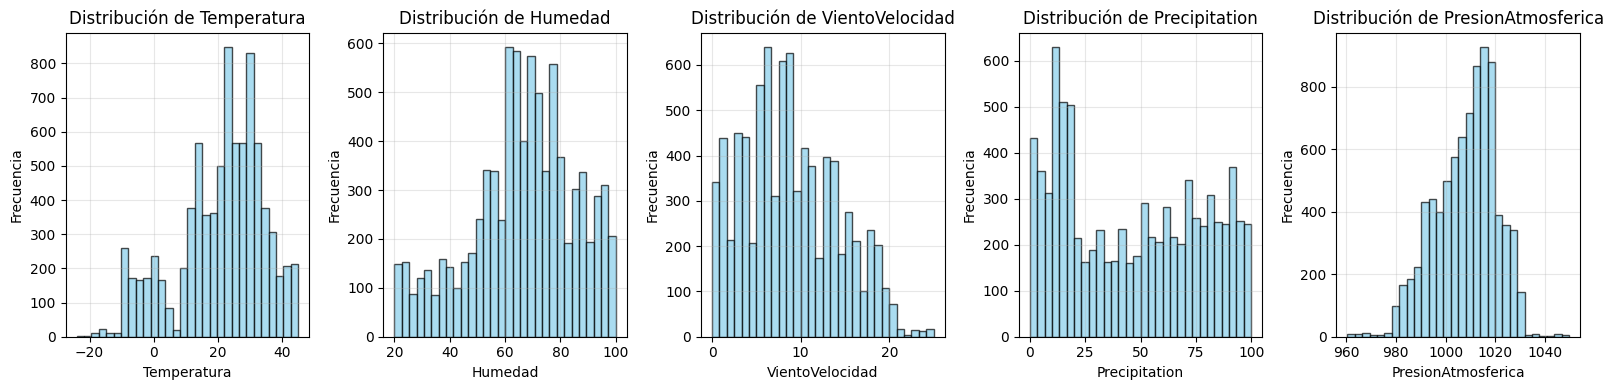

In [10]:
#Distribución de variables numéricas
columnas_numericas = ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica']

fig, axes = plt.subplots(1, 5, figsize=(16, 4))

for i, col in enumerate(columnas_numericas):
    axes[i].hist(estaciones[col], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_title(f'Distribución de {col}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Temperatura:** La distribución es multimodal. Se ve concentraciones alrededor de los 10-15°C y cerca de los 30°C. También hay una concentración de valores en temperaturas bajo cero. Esto sugiere que los datos provienen de poblaciones distintas, probablemente correspondiendo a las diferentes estaciones del año.

**Humedad:** Muestra un sesgo a la izquierda. La mayoría de los valores se concentran en el rango alto (60-100%), con una cola que se extiende hacia valores más bajos.

**VientoVelocidad:** Tiene un fuerte sesgo a la derecha. La gran mayoría de las mediciones son de vientos de baja velocidad (menos de 15 km/h), y hay una larga cola de valores menos frecuentes pero mucho más altos.

**Precipitation:** La distribución es bastante uniforme en todo el rango de 0 a 100.

**PresionAtmosferica:** Distribución semejante a una distribución normal, con un pico centrado ligeramente por encima de 1000 hPa y una disminución simétrica hacia ambos lados.

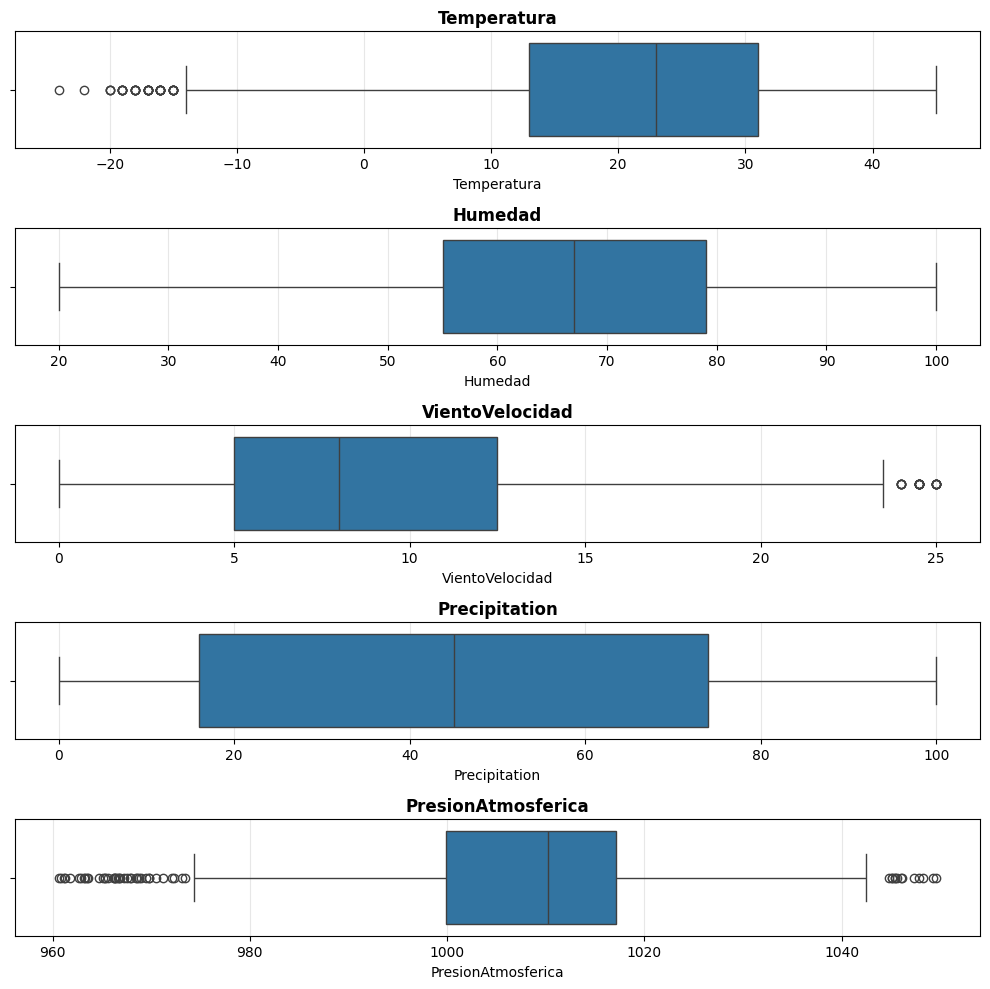

In [11]:
# Boxplot de las variables numéricas (uno debajo del otro)
fig, axes = plt.subplots(5, 1, figsize=(10, 10))

for i, col in enumerate(columnas_numericas):
    sns.boxplot(x=estaciones[col], ax=axes[i], orient='h')
    axes[i].set_xlabel(col)
    axes[i].set_title(f'{col}', fontweight='bold')
    axes[i].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

Temperatura: Después del filtrado casi no quedan valores atípicos. La mediana se mantiene alrededor de 23°C y el rango se vuelve consistente con temperaturas ambientales reales.

Humedad: Tras eliminar registros inválidos (como valores mayores al 100%), la distribución queda limpia y la mediana permanece cerca del 70%, sin outliers relevantes.

VientoVelocidad: El filtrado reduce significativamente los valores extremos. La mediana continúa cerca de 10 km/h y los datos se ajustan a rangos meteorológicamente razonables.

Precipitation: Se eliminan valores incoherentes y la mediana continúa alrededor de 50. La distribución conserva su forma pero sin outliers impropios.

PresionAtmosferica: El filtrado elimina numerosos registros fuera de rango. La mediana se mantiene cerca de 1015 hPa y el conjunto queda dentro de valores atmosféricos normales.

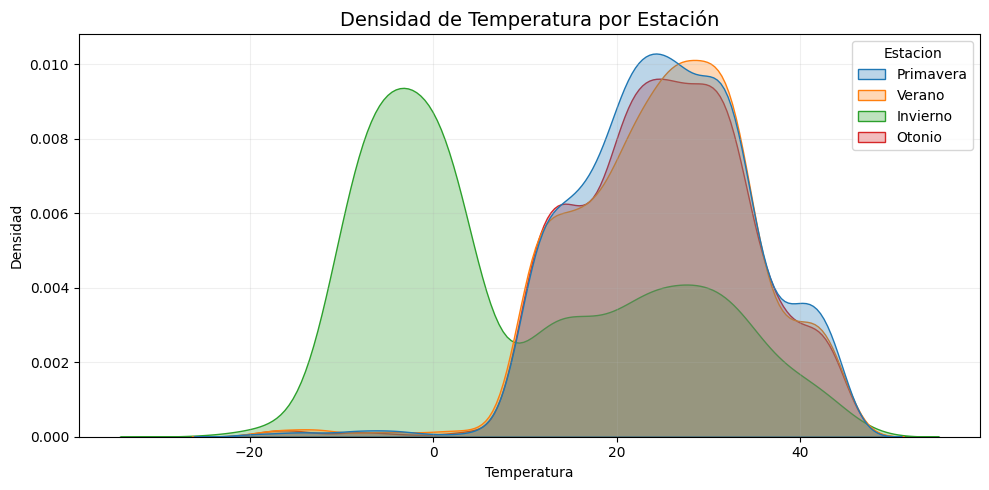

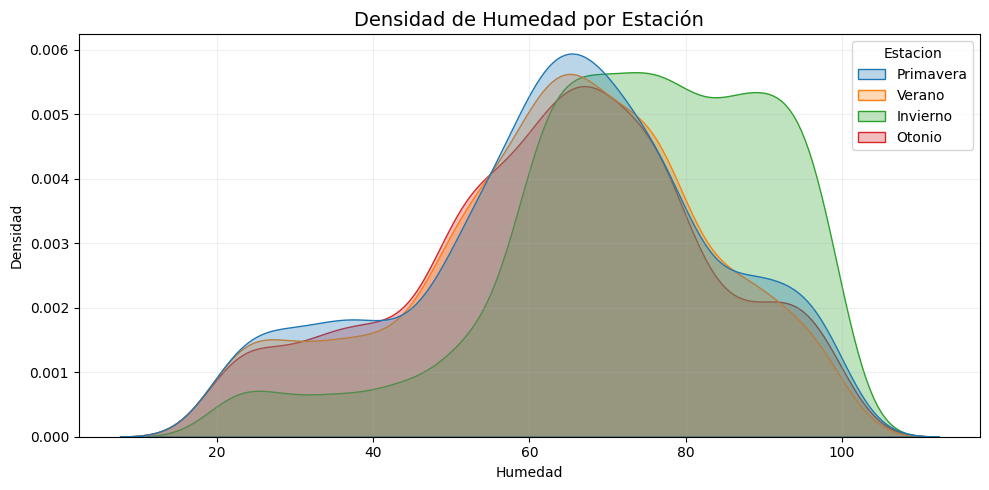

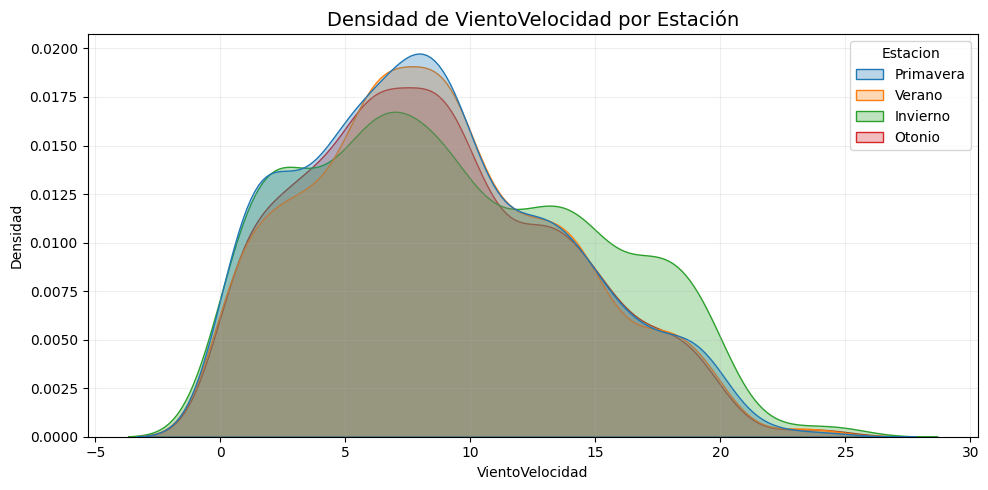

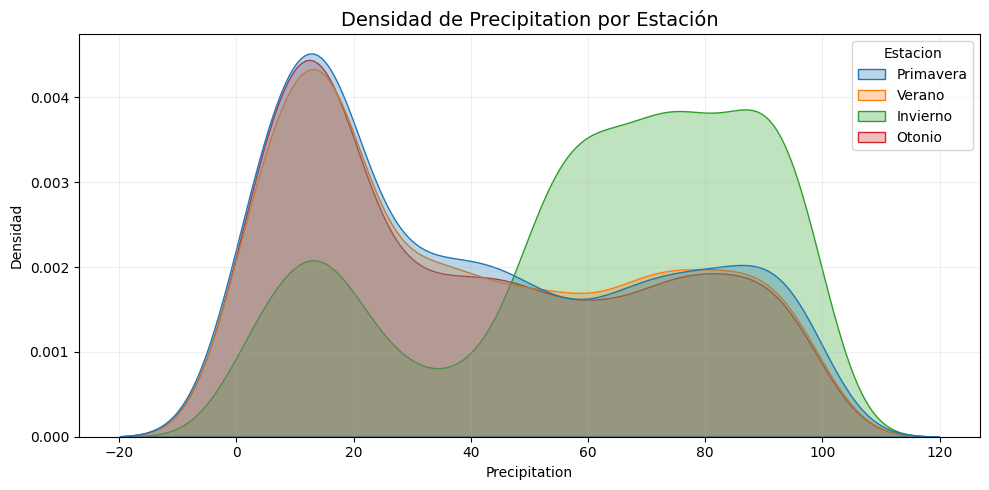

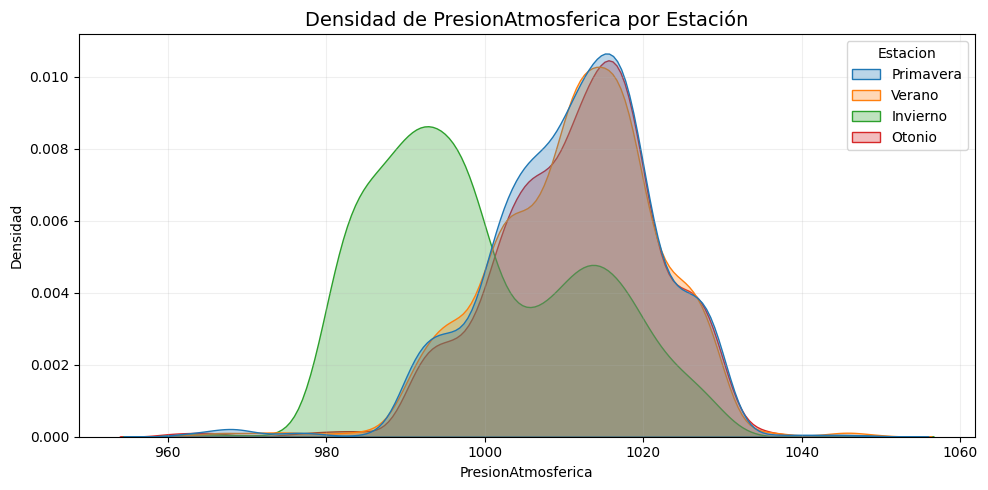

In [12]:
columnas_numericas = ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica']

for col in columnas_numericas:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=estaciones, x=col, hue='Estacion', fill=True, alpha=0.3)
    plt.title(f'Densidad de {col} por Estación', fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Densidad")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

Observamos que la única estación que se distingue (principalmente por la temperatura, la precipitación y presión atmosférica) es invierno, ya que las otras tienen muchas similitudes.

### Matriz de correlación

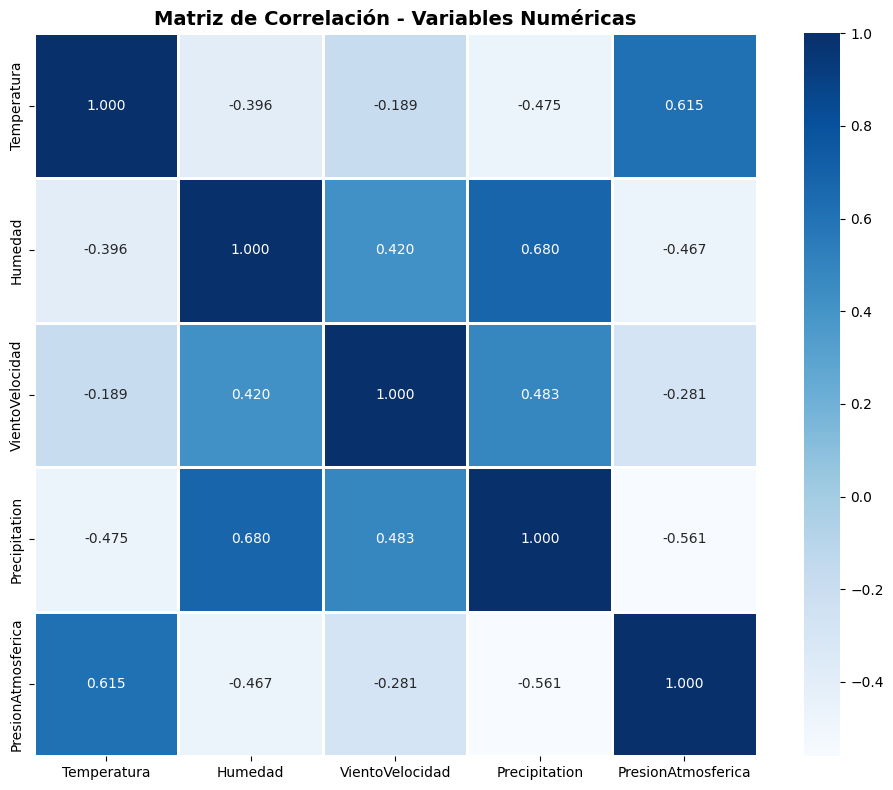

In [13]:
datos_numericos = estaciones.select_dtypes(include=[np.number])
matriz_correlacion = datos_numericos.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, fmt='.3f', cmap='Blues', square=True, linewidths=1)
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Correlación positiva fuerte (0.635) entre Humedad y Precipitation, es lógico: A mayor humedad, es más probable que haya precipitación.

Correlaciones positivas moderadas:

VientoVelocidad y Precipitation (0.465): El viento puede transportar nubes y humedad, lo que influye en la precipitación.

Humedad y VientoVelocidad (0.424): Similar al punto anterior, el viento afecta la distribución de la humedad.

Correlación negativa débil (-0.205) entre Temperatura y Precipitation: En algunos climas, las temperaturas más bajas están asociadas con la lluvia o la nieve.
Otras correlaciones son muy débiles (cercanas a cero), lo que indica que esas variables no tienen una relación lineal fuerte entre sí.

## Variables categóricas

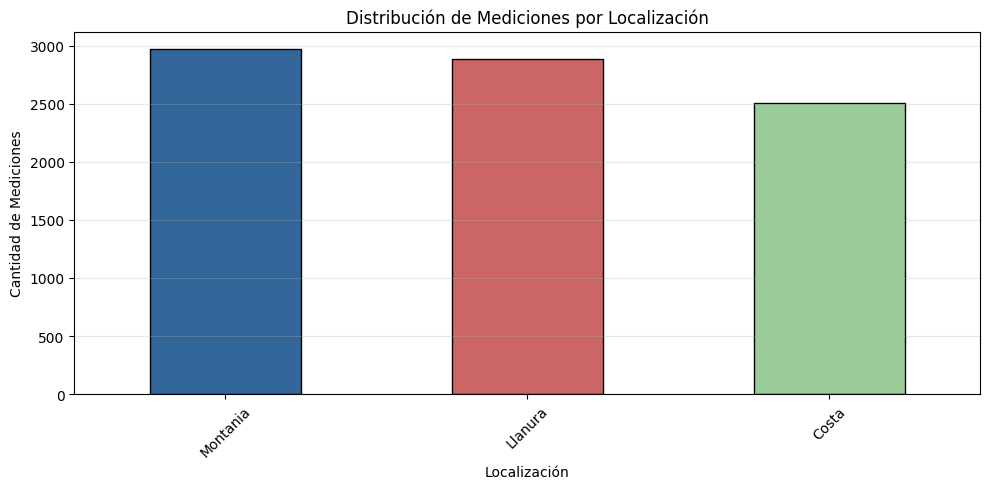


Distribución por Estado:
Localizacion
Montania    2970
Llanura     2884
Costa       2508
Name: count, dtype: int64

Porcentaje por Estado:
Localizacion
Montania    35.52
Llanura     34.49
Costa       29.99
Name: count, dtype: float64


In [14]:
conteo_estados = estaciones['Localizacion'].value_counts()

paleta = ['#336699', '#CC6666', '#99CC99']

plt.figure(figsize=(10, 5))
conteo_estados.plot(kind='bar', color=paleta, edgecolor='black')
plt.xlabel('Localización')
plt.ylabel('Cantidad de Mediciones')
plt.title('Distribución de Mediciones por Localización')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nDistribución por Estado:")
print(conteo_estados)
print(f"\nPorcentaje por Estado:")
print((conteo_estados / len(estaciones) * 100).round(2))

Se puede observar que la distribución de las mediciones entre las localizaciones es relativamente balanceada.

No hay una categoría que domine de forma desproporcionada. Esto significa que el dataset tiene una representación sólida de todas las localizaciones.

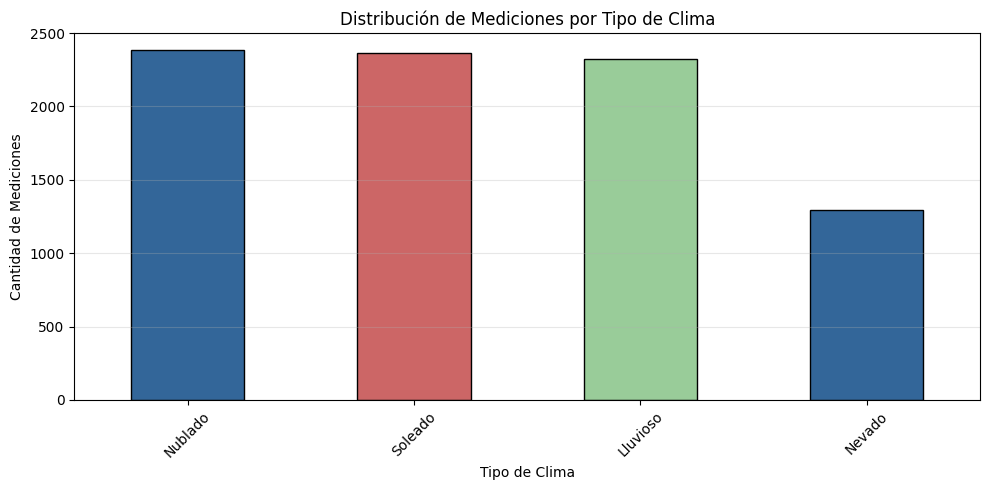


Distribución por Estado:
TipoClima
Nublado     2383
Soleado     2365
Lluvioso    2322
Nevado      1292
Name: count, dtype: int64

Porcentaje por Estado:
TipoClima
Nublado     28.50
Soleado     28.28
Lluvioso    27.77
Nevado      15.45
Name: count, dtype: float64


In [15]:
conteo_estados = estaciones['TipoClima'].value_counts()

paleta = ['#336699', '#CC6666', '#99CC99']

plt.figure(figsize=(10, 5))
conteo_estados.plot(kind='bar', color=paleta, edgecolor='black')
plt.xlabel('Tipo de Clima')
plt.ylabel('Cantidad de Mediciones')
plt.title('Distribución de Mediciones por Tipo de Clima')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nDistribución por Estado:")
print(conteo_estados)
print(f"\nPorcentaje por Estado:")
print((conteo_estados / len(estaciones) * 100).round(2))

Las categorías Soleado, Lluvioso y Nublado están muy bien balanceadas entre sí. Cada una representa alrededor del 28% de los datos.

La categoría Nevado es notablemente menos frecuente, constituyendo solo el 15.9% del total de las mediciones.

**En conclusión:**   Hay un desbalance. La clase Nevado es una clase minoritaria en comparación con las otras tres. Esto es importante tenerlo en cuenta, ya que los modelos de clasificación a veces tienden a favorecer a las clases mayoritarias.

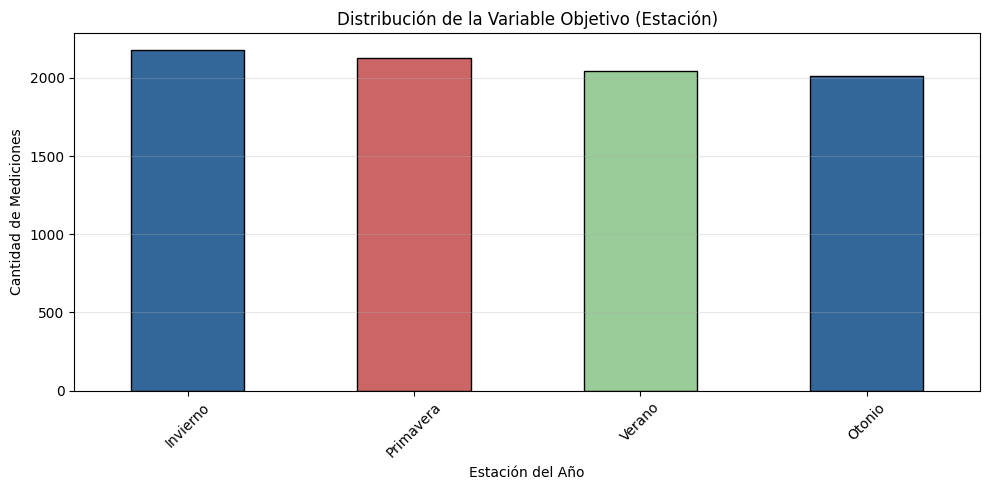


Distribución por Estado:
Estacion
Invierno     2179
Primavera    2129
Verano       2043
Otonio       2011
Name: count, dtype: int64

Porcentaje por Estado:
Estacion
Invierno     26.06
Primavera    25.46
Verano       24.43
Otonio       24.05
Name: count, dtype: float64


In [16]:
conteo_estados = estaciones['Estacion'].value_counts()

paleta = ['#336699', '#CC6666', '#99CC99']

plt.figure(figsize=(10, 5))
conteo_estados.plot(kind='bar', color=paleta, edgecolor='black')
plt.xlabel('Estación del Año')
plt.ylabel('Cantidad de Mediciones')
plt.title('Distribución de la Variable Objetivo (Estación)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nDistribución por Estado:")
print(conteo_estados)
print(f"\nPorcentaje por Estado:")
print((conteo_estados / len(estaciones) * 100).round(2))

Las clases estan relativamente balanceadas.

El modelo tendrá la misma cantidad de ejemplos para aprender de cada estación.

No se necesitan técnicas especiales para tratar con datos desbalanceados.

### Falta conclusion parcial

### Cositas para agregar

Scatterplot con hue: Graficar la relación entre dos variables numéricas, pero coloreando los puntos según una categoría.

por ejemplo un gráfico de Temperatura vs. Humedad, con los puntos coloreados por Estacion, podría mostrar "clusters" o agrupaciones claras. 
Por ejemplo, puntos de Verano podrían agruparse en la zona de alta temperatura y alta humedad, mientras que los de Invierno estarían en la zona de baja temperatura.


Ejemplo: sns.scatterplot(x='Temperatura', y='Humedad', hue='Estacion', data=estaciones)

---
pairplot para ver matrixz de gragicos de variables numericas y probar tambien con HUE estacion

# Preprocesamiento

In [17]:
# Separamos las características y el objetivo

X = estaciones.drop('Estacion', axis=1)
y = estaciones['Estacion']

# Split de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
# Identificamos columnas numéricas y categóricas
columnas_numericas = ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica']
columnas_categoricas = ['Localizacion', 'TipoClima']

# transformador de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), columnas_categoricas)
    ],
    remainder='passthrough'
)

In [19]:
# Definimos los 5 folds

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits = list(skf.split(X, y))


# Tomamos SOLO el primer fold para optimizar hiperparámetros
train_idx, val_idx = splits[0]
X_train_t, X_val_t = X.iloc[train_idx], X.iloc[val_idx]
y_train_t, y_val_t = y.iloc[train_idx], y.iloc[val_idx]


# Implementación de SVM con Kernel Lineal

In [20]:
pipeline_svm_lin = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', random_state=42))
])

param_grid_svm_lin = {
    'classifier__C': [0.1, 1, 10]
}

scoring_metrics = {
    'acc': 'accuracy',
    'prec': 'precision_macro',
    'rec': 'recall_macro'
}

grid_lin = GridSearchCV(
    pipeline_svm_lin,
    param_grid=param_grid_svm_lin,
    cv=5,
    scoring=scoring_metrics,
    refit='prec'      # optimizamos por precisión macro
)

grid_lin.fit(X_train_t, y_train_t)

print("Mejores hiperparámetros (SVM lineal):", grid_lin.best_params_)

best_C = grid_lin.best_params_["classifier__C"]


Mejores hiperparámetros (SVM lineal): {'classifier__C': 0.1}


In [21]:
accs, precs, recs = [], [], []

for train_idx, test_idx in splits:
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # modelo final con el mejor C
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(kernel='linear', C=best_C, random_state=42))
    ])
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accs.append(accuracy_score(y_test, y_pred))
    precs.append(precision_score(y_test, y_pred, average="macro", zero_division=0))
    recs.append(recall_score(y_test, y_pred, average="macro", zero_division=0))

print("Exactitud promedio:", sum(accs)/5)
print("Precisión promedio:", sum(precs)/5)
print("Exhaustividad promedio:", sum(recs)/5)


Exactitud promedio: 0.39655562451202175
Precisión promedio: 0.4204384980268404
Exhaustividad promedio: 0.38919585969496817


### Conclusion SVM con kernel lineal

El modelo no está rindiendo: la exactitud ronda el 40% y precisión/exhaustividad están apenas arriba o abajo de eso. Eso indica que el separador lineal no está capturando bien las diferencias entre estaciones; básicamente, el problema no es lineal o los atributos no aportan una estructura clara para que una frontera recta funcione. 

El C óptimo es 0.1 y eso apunta a que el mejor compromiso fue no sobreajustar, pero aun así el desempeño queda pobre. 

La precisión levemente superior a la exhaustividad sugiere que cuando el modelo acierta lo hace con razonable seguridad, pero sigue dejando muchas clases sin cubrir bien. 


# Implementación de SVM con Kernel Gaussiano

In [27]:
pipeline_svm_rbf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf'))
])

param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 0.01, 0.1, 1]
}

grid = GridSearchCV(
    pipeline_svm_rbf,
    param_grid,
    cv=5,
    scoring='precision_macro',
    refit=True
)

grid.fit(X_train_t, y_train_t)

best_C = grid.best_params_['classifier__C']
best_gamma = grid.best_params_['classifier__gamma']

print("Mejores hiperparámetros (SVM RBF):", grid.best_params_)



Mejores hiperparámetros (SVM RBF): {'classifier__C': 0.1, 'classifier__gamma': 1}


In [23]:
pipeline_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', C=best_C, gamma=best_gamma))
])

accs, precs, recs = [], [], []

for train_idx, val_idx in skf.split(X, y):
    X_train_t, X_val_t = X.iloc[train_idx], X.iloc[val_idx]
    y_train_t, y_val_t = y.iloc[train_idx], y.iloc[val_idx]

    pipeline_final.fit(X_train_t, y_train_t)
    y_pred = pipeline_final.predict(X_val_t)

    accs.append(accuracy_score(y_val_t, y_pred))
    precs.append(precision_score(y_val_t, y_pred, average="macro", zero_division=0))
    recs.append(recall_score(y_val_t, y_pred, average="macro", zero_division=0))

print("Exactitud promedio:", np.mean(accs))
print("Precisión promedio:", np.mean(precs))
print("Exhaustividad promedio:", np.mean(recs))

Exactitud promedio: 0.3995459836353913
Precisión promedio: 0.4645651801903134
Exhaustividad promedio: 0.389339378599667


### Conclusiones SVM con Kernel Gaussiano

El mejor modelo encontró C = 0.1 y γ = 1. Un C bajo implica que el modelo prefiere márgenes amplios aun si eso significa cometer errores, es un indicio claro de que tratar de ajustar fuerte no ayuda, porque el modelo empeora. γ = 1 es un valor relativamente alto para RBF, controla cuánta curvatura tiene la frontera. Que el óptimo sea γ alto muestra que el modelo intenta curvarse para capturar estructura local, pero aun así el dataset no ofrece patrones claros que permitan separar las estaciones de forma útil.

en resumen: ni aumentando la flexibilidad (γ) ni penalizando más/menos los errores aparece una estructura real que el modelo pueda explotar.

---

Las demàs métricas muestran un rendimiento pobre: la exactitud ronda el 0.40, como el svm con kernel lineal; la precisión llega a 0.46, lo que indica que el modelo acierta un poco más cuando predice una clase y la exhaustividad se mantiene cerca del 0.39, señal de que no logra cubrir bien las instancias reales de cada categoría. 

Analizando esto, el modelo está captando muy poca estructura útil del dataset y no logra separar adecuadamente las clases. No mejora sustancialmente el SVM con kernel lineal

# Implementación de Random Forest   

In [24]:
param_grid_rf = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [None, 5, 10, 20]
}

pipeline_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid=param_grid_rf,
    cv=[(train_idx, val_idx)],   # SOLO un fold, como exige el enunciado
    scoring={
        "acc": "accuracy",
        "prec": "precision_macro",
        "rec": "recall_macro"
    },
    refit="prec"
)

grid_search_rf.fit(X, y)
best_params_rf = grid_search_rf.best_params_
best_params_rf


{'classifier__max_depth': 5, 'classifier__n_estimators': 200}

In [25]:
best_n = best_params_rf["classifier__n_estimators"]
best_d = best_params_rf["classifier__max_depth"]

accs, precs, recs = [], [], []

for train_idx, test_idx in splits:
    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(
            n_estimators=best_n,
            max_depth=best_d,
            random_state=42
        ))
    ])
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accs.append(accuracy_score(y_test, y_pred))
    precs.append(precision_score(y_test, y_pred, average="macro", zero_division=0))
    recs.append(recall_score(y_test, y_pred, average="macro", zero_division=0))



In [26]:
print("Exactitud promedio:", sum(accs)/5)
print("Precisión promedio:", sum(precs)/5)
print("Exhaustividad promedio:", sum(recs)/5)


Exactitud promedio: 0.39344693513929363
Precisión promedio: 0.4560293726186546
Exhaustividad promedio: 0.3865773707737564


### Conclusiones Random Forest

El mejor modelo usó 200 árboles y profundidad máxima 5, lo cual ya indica que el bosque necesitó muchos estimadores para estabilizarse pero no ganó nada dejando crecer los árboles: profundidades mayores no aportaron señal útil. Aun con esos hiperparámetros, el rendimiento es flojo. 

La exactitud queda cerca de 0.39, apenas por encima del azar; la precisión ronda 0.45, lo que muestra que discrimina mal entre estaciones; y la exhaustividad cae a 0.38, señal de que deja afuera buena parte de los casos reales.
En resumen, el modelo no está capturando patrones relevantes, y ajustar cantidad de árboles o profundidad no cambia el panorama. Esto realmente refuerza nuestra hipótesis de que el problema es la falta de estructura útil en el dataset

# CONCLUSIONES GENERALES

Los tres modelos SVM lineal, SVM con kernel gaussiano y Random Forest, convergen en el mismo diagnóstico: el dataset no ofrece patrones suficientemente diferenciados para predecir la Estación de manera confiable. Ningún algoritmo supera una exactitud promedio del 0.40, y tanto la precisión como la exhaustividad se mantienen alrededor de 0.38 a 0.46, lo que es pobre para un problema multiclase. 

Ajustar hiperparámetros no cambió sustancialmente nada: ni variar el costo en el SVM lineal, ni explorar combinaciones de C y gamma en el kernel RBF, ni incrementar estimadores o profundidad en el Random Forest produjo mejoras reales. El rendimiento queda limitado por la falta de señal en las variables disponibles. 

En resumen, el problema no es la elección del modelo sino la baja capacidad predictiva inherente a los datos: los clasificadores solo logran un nivel marginalmente mejor que el azar, lo que indica que la Estación no está determinada de forma clara por los atributos usados.